# Procesa indicadores

Jupyter notebook con el procesamiento y cálculo de índices e indicadores de Complejidad Económica

In [249]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

## Importa bases

In [250]:
DATASETS_DIR = './datasets/'
variable = 'empleo'

In [251]:
# Importamos la base para trabajar
empleo_depto_act = pd.read_csv(DATASETS_DIR + "Datos_por_departamento_y_actividad.csv")
empleo_depto_act.head()

,in_departamentos,departamento,provincia_id,provincia,clae6,clae2,letra,Empleo,Establecimientos
0,30077,Nogoyá,30,Entre Rios,475230,47,G,3,2
1,70070,Pocito,70,San Juan,13019,1,A,39,8
2,2105,Comuna 15,2,CABA,141201,14,C,12,4
3,62021,Bariloche,62,Rio Negro,702092,70,M,36,9
4,6609,Pehuajó,6,Buenos Aires,14113,1,A,266,85


In [252]:
# Por decisión metodológica, vamos a considerar a CABA dentro de la provincia de Buenos Aires, por lo que reemplazamos su nombre y código.
empleo_depto_act.provincia = empleo_depto_act.provincia.replace('CABA', 'Buenos Aires')
empleo_depto_act.provincia_id = empleo_depto_act.provincia_id.replace(2, 6)

In [253]:
empleo_depto_act.shape

(96379, 9)

## Calcula Location quotients o Ventajas Comparativas Reveladas
Una economía está especializada en la producción de un bien o servicio cuando la participación del mismo en su empleo total sea superior a la participación del empleo de ese producto o servicio en el total de Argentina. Este cálculo es usualmente conocido como el de las Ventajas Comparativas Reveladas (VCR), aunque en la literatura de CE y empleo se lo puede conocer también como especialización o *location quotient*. De esta manera entonces, la especialización de una provincia *p* en una actividad *a* y siendo $E_{pa}$ el empleo de una provincia en una actividad, se va a calcular como:

$$
LC_{pa} = \dfrac{E_{pa} / \sum_{c} E_{pa}}{\sum_{a} E_{pa} / \sum_{p} \sum_{a} E_{pa}}
$$

In [254]:
#Matriz de empleo por provincia y actividad. Sería Xcp.

df_base = empleo_depto_act[['provincia_id', 'provincia', 'clae6', 'Empleo']].copy()
df_base.rename(columns = {'Empleo':'empleo'}, inplace = True)
df_base.clae6 = df_base.clae6.apply(lambda x: f'{x:06}')
df_base.head()

,provincia_id,provincia,clae6,empleo
0,30,Entre Rios,475230,3
1,70,San Juan,013019,39
2,6,Buenos Aires,141201,12
3,62,Rio Negro,702092,36
4,6,Buenos Aires,014113,266


In [255]:
# Dado que los cálculos se hacen a nivel provincial y están desagregados por departamento, entonces hay que agrupar los datos de empleo.

df_base = df_base.groupby(['provincia','provincia_id', 'clae6'])[[variable]].sum().reset_index().sort_values(by =['provincia_id', 'clae6'])
df_base.head()

,provincia,provincia_id,clae6,empleo
0,Buenos Aires,6,011111,137
1,Buenos Aires,6,011112,2848
2,Buenos Aires,6,011119,11784
3,Buenos Aires,6,011121,725
4,Buenos Aires,6,011129,446


In [256]:
# Calculamos el vector de empleo total por provincia (sum p Xcp)

df_agrup_p = df_base.groupby(['provincia_id'])[[variable]].sum()
df_agrup_p.head()

,empleo
provincia_id,
6,3536103
10,29036
14,511735
18,78844
22,82772


In [257]:
# Calculamos el ratio que representa el empleo de una actividad en el empleo de la provincia

df_prov = df_base.merge(df_agrup_p, how='left', on='provincia_id')
df_prov['porc_prov']=df_prov[f'{variable}_x']/df_prov[f'{variable}_y' ]
df_prov.head()

,provincia,provincia_id,clae6,empleo_x,empleo_y,porc_prov
0,Buenos Aires,6,011111,137,3536103,0.000039
1,Buenos Aires,6,011112,2848,3536103,0.000805
2,Buenos Aires,6,011119,11784,3536103,0.003332
3,Buenos Aires,6,011121,725,3536103,0.000205
4,Buenos Aires,6,011129,446,3536103,0.000126


In [258]:
#Calculamos el vector de empleo total por actividad (sum c Xcp)

df_agrup_a = df_base.groupby(['clae6'])[[variable]].sum()
df_agrup_a.head()

,empleo
clae6,
011111,2814
011112,4429
011119,21212
011121,2337
011129,850


In [259]:
# Calculo empleo total de Argentina para denominador

df_agrup_pa = df_agrup_a[variable].sum()
df_agrup_pa

6282235

In [260]:
# Calculamos el ratio que representan el empleo de una actividad sobre el total de empleo

df_agrup_a[f'{variable}_total'] = df_agrup_pa
df_agrup_a['porc_act'] = df_agrup_a[variable]/df_agrup_a[f'{variable}_total']
df_agrup_a.head()

,empleo,empleo_total,porc_act
clae6,,,
011111,2814,6282235,0.000448
011112,4429,6282235,0.000705
011119,21212,6282235,0.003377
011121,2337,6282235,0.000372
011129,850,6282235,0.000135


In [261]:
# Unimos ambas tablas para tener ambos ratios y calculamos la RCA y M.

df_RCA = df_prov.merge(df_agrup_a, how='left', on='clae6')

df_RCA['RCA'] = df_RCA['porc_prov'] / df_RCA['porc_act']
df_RCA['M'] = np.where(df_RCA['RCA'] >= 1, 1, 0)

df_RCA.drop(columns=[variable, f'{variable}_total', f'{variable}_y'],inplace=True)
df_RCA.rename(columns={f'{variable}_x': variable}, inplace=True)
    
df_RCA.head()

,provincia,provincia_id,clae6,empleo,porc_prov,porc_act,RCA,M
0,Buenos Aires,6,011111,137,0.000039,0.000448,0.086494,0
1,Buenos Aires,6,011112,2848,0.000805,0.000705,1.142414,1
2,Buenos Aires,6,011119,11784,0.003332,0.003377,0.986962,0
3,Buenos Aires,6,011121,725,0.000205,0.000372,0.551148,0
4,Buenos Aires,6,011129,446,0.000126,0.000135,0.932192,0


In [262]:
# Exploramos la cantidad de actividades con RCA por provincia
df_RCA.groupby('provincia')[['M']].sum().sort_values(by='M', ascending=False)

,M
provincia,
Buenos Aires,507
Santa Fe,333
Cordoba,302
Mendoza,264
Entre Rios,245
Rio Negro,231
Chubut,228
Santiago Del Estero,228
San Juan,228


In [263]:
# Transformamos las columnas en índices fijos para provincias y actividades para poder transportar la matriz a numpy:
provincias_id = df_RCA.provincia_id.unique()
provincias = df_RCA.provincia.unique()
actividades = df_RCA.clae6.unique()

df_RCA['loc_int'] = df_RCA.provincia_id.apply(lambda x: np.where(provincias_id == x)[0][0])
df_RCA['prod_int'] = df_RCA.clae6.apply(lambda x: np.where(actividades == x)[0][0])
df_RCA.head()

,provincia,provincia_id,clae6,empleo,porc_prov,porc_act,RCA,M,loc_int,prod_int
0,Buenos Aires,6,011111,137,0.000039,0.000448,0.086494,0,0,0
1,Buenos Aires,6,011112,2848,0.000805,0.000705,1.142414,1,0,1
2,Buenos Aires,6,011119,11784,0.003332,0.003377,0.986962,0,0,2
3,Buenos Aires,6,011121,725,0.000205,0.000372,0.551148,0,0,3
4,Buenos Aires,6,011129,446,0.000126,0.000135,0.932192,0,0,4


## Calcula matriz M
A partir del cálculo de los LQ o RCA se obtiene la matriz M:
$$
M_{pa} =
\begin{cases} 
1 & \text{si } LQ_{pa} \geq 1 \\
0 & \text{si } LQ_{pa} < 1
\end{cases}
$$

In [264]:
# Creamos una matriz de ceros para guardar la matriz M y relleno
Mpa = np.zeros((df_RCA.provincia_id.nunique(), df_RCA.clae6.nunique()),
               dtype=np.int64)

for row in df_RCA.loc[df_RCA.M == 1].iterrows():
    Mpa[row[1].loc_int, row[1].prod_int] = 1

In [265]:
print('Cuantos elementos tienen RCA > 1 segun df_RCA:', len(df_RCA.loc[df_RCA.M == 1]))
print('Cuantos elementos tienen RCA > 1 segun Mpa:   ', Mpa.sum())

Cuantos elementos tienen RCA > 1 segun df_RCA: 5308
Cuantos elementos tienen RCA > 1 segun Mpa:    5308


### Calcula Diversidad
La diversidad de una provincia se calcula como el número de industrias en la que la misma es competitiva.

$$
Diversidad = k_{p,0} = \sum_{a} M_{pa}
$$

In [266]:
diversity = Mpa.sum(axis = 1)
diversity.shape

(23,)

### Calcula Ubicuidad
La ubicuidad de una industria se calcula como el número de provincias en que una la misma se encuentra concentrada
$$
Ubicuidad = k_{a,0} = \sum_{p} M_{pa}
$$

In [267]:
ubiquity = Mpa.sum(axis = 0)
ubiquity.shape

(943,)

### Calcula las inversas

In [268]:
D_inv = np.diag(1/diversity)
D_inv.shape


(23, 23)

In [269]:
U_inv = np.diag(1/ubiquity)
U_inv.shape

(943, 943)

## Calcula matriz $\tilde{M}$
Para calcular la complejidad de las provincias, el Índice de Complejidad Económica (ICE) tenemos en primer lugar que calcular la matriz $\tilde{M}$ utilizando las inversas de la ubicuidad y de la diversidad y la propia matriz M y M transpuesta.

$$ 
\tilde{M} = D^{-1} M U^{-1} M'  \\

\tilde{M} = D^{-1} S
$$

In [270]:
temp_Mpa_1 = Mpa.copy().astype(float)
for i in range(len(actividades)):
    temp_Mpa_1[:, i] = temp_Mpa_1[:, i]/ubiquity[i]

In [271]:
temp_Mpa_1.dtype, temp_Mpa_1.shape
Sccprima = np.matmul(temp_Mpa_1, Mpa.transpose())
Sccprima.shape

(23, 23)

In [272]:
Mmonio_c = np.matmul(D_inv, Sccprima)
Mmonio_c.shape

(23, 23)

## Calcula los autovalores, autovectores, ECI

In [273]:
def calc_complexity(mmonio):
    autovalores, autovectores = np.linalg.eig(mmonio)
    second_idx = np.where(autovalores == -np.sort(-autovalores)[1])[0][0]
    
    # el segundo autovector es la varianza de complejidades: el ECI
    complexity = autovectores[:, second_idx].real
    print('Todos los avec imaginarios son cero:', (np.isclose(autovectores[:, second_idx].imag, 0.0)).all())
    print('Mean and std of second autovector:', complexity.mean(), '+/-', complexity.std())
    return complexity

In [274]:
eci_raw = calc_complexity(Mmonio_c)
eci_norm = (eci_raw - eci_raw.mean())/eci_raw.std()
eci_norm = -eci_norm
print('Mean and std of eci:', eci_norm.mean(), '+/-', eci_norm.std())

Todos los avec imaginarios son cero: True
Mean and std of second autovector: 0.05530617717941411 +/- 0.20104598388270395
Mean and std of eci: -2.896233977283017e-17 +/- 1.0000000000000002


In [275]:
# Exploramos cuál es el ECI de cada provincia

df_eci = pd.DataFrame({'provincia': provincias, 'ECI': eci_norm})
df_eci.sort_values('ECI', ascending=False, inplace=True)
df_eci.merge(df_RCA.groupby('provincia')[['M']].sum().sort_values(by='M', ascending=False).reset_index(),how='left')

,provincia,ECI,M
0,Buenos Aires,4.231254,507
1,Santa Fe,1.236544,333
2,Cordoba,0.499901,302
3,Tierra Del Fuego,0.474662,169
4,San Luis,0.259899,199
5,Mendoza,-0.084972,264
6,San Juan,-0.228591,228
7,Tucuman,-0.233229,186
8,Misiones,-0.234125,186
9,Chaco,-0.254351,212


## Calcula matriz $\hat{M}$
Para calcular la complejidad de las actividades, el Índice de Complejidad de las Actividades (ICA) tenemos en primer lugar que calcular la matriz $\hat{M}$ utilizando las inversas de la ubicuidad y de la diversidad y la propia matriz M y M transpuesta.

$$ 
\hat{M} = U^{-1} M' D^{-1} M
$$

In [276]:
temp_Mpa_2 = Mpa.copy().astype(float)
for i in range(len(provincias)):
    temp_Mpa_2[i, :] = temp_Mpa_2[i, :]/diversity[i]

In [277]:
Sppprima = np.matmul(Mpa.transpose(), temp_Mpa_2)
Sppprima.shape, Sppprima.dtype

((943, 943), dtype('float64'))

In [278]:
Mmonio_p = np.matmul(U_inv, Sppprima)
Mmonio_p.shape, Mmonio_p.dtype

((943, 943), dtype('float64'))

In [279]:
ica_raw = calc_complexity(Mmonio_p)
ica_norm = (ica_raw - ica_raw.mean())/ica_raw.std()
print('Mean and std of ICA:', ica_norm.mean(), '+/-', ica_norm.std())

Todos los avec imaginarios son cero: True
Mean and std of second autovector: -0.012551129432374308 +/- 0.030048536354277778
Mean and std of ICA: -1.5069835328952285e-17 +/- 0.9999999999999999


In [280]:
# El autovector sale acá con el signo invertido así que lo cambiamos
ica_norm = -ica_norm

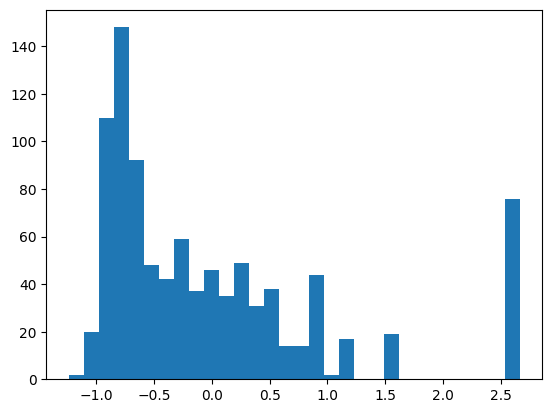

In [281]:
# Exploramos la distribución del ICA. 
plt.hist(ica_norm, bins=30)
plt.show()

In [282]:
# Preparamos ciertos arrays para exportar 

RCA = np.zeros((df_RCA.provincia_id.nunique(), df_RCA.clae6.nunique()),
               dtype=np.float64)

for row in df_RCA.loc[df_RCA.RCA != 0.0].iterrows():
    RCA[row[1].loc_int, row[1].prod_int] = row[1].RCA

empleo = np.zeros((df_RCA.provincia_id.nunique(), df_RCA.clae6.nunique()),
               dtype=np.float64)

# llena de RCA en los lugares correspondientes segun df_RCA
for row in df_RCA.iterrows():
    empleo[row[1].loc_int, row[1].prod_int] = row[1].empleo

In [283]:
df_RCA.to_excel('dataframes/df_RCA.xlsx', index=False)

In [284]:
# Pasamos todo lo procesado hasta acá a pickles

with open(f'serializables/Mpa.pkl','wb') as f:
    pickle.dump(Mpa, f)

with open(f'serializables/clae6.pkl','wb') as f:
    pickle.dump(actividades, f)

provincias = df_RCA.provincia.unique()
with open(f'serializables/provincias.pkl','wb') as f:
    pickle.dump(provincias, f)

with open(f'serializables/RCA.pkl','wb') as f:
    pickle.dump(RCA, f)

with open(f'serializables/eci.pkl','wb') as f:
    pickle.dump(eci_norm, f)

with open(f'serializables/ica.pkl','wb') as f:
    pickle.dump(ica_norm, f)

with open(f'serializables/empleo.pkl','wb') as f:
    pickle.dump(empleo, f)

## Calcula proximidades
Siguiendo con el cálculo de indicadores, calculamos la proximidad de dos actividades *a* y *a'* como la probabilidad condicional de co-localizarse en una provincia *p*.
$$
\phi_{a,a'} = \min \left( \dfrac{\sum_{p} M_{pa} M_{pa'}}{\sum_{p} M_{pa}}, \dfrac{\sum_{p} M_{pa} M_{pa'}}{\sum_{p} M_{pa'}} \right).
$$

In [285]:
p_RCAmay1 = np.zeros((len(actividades),))

for prod in range(len(actividades)):
    p_RCAmay1[prod] = Mpa[:, prod].sum()

In [286]:
# Calculamos la proximidad: la probabilidad condicional mínima de que una icaa tenga el sector i RCA>1 dado tiene el sector j con RCA>1, y viceversa.
# Miramos entonces primero la cantidad de icas en que ambos sectores tienen RCA, lo sumo y divido por la mayor ubicuidad de ambos sectores.

almost_proximity = np.zeros((len(actividades), len(actividades)))

for p1 in range(len(actividades)-1):
    # como es una matriz simetrica, calcula unicamente la mitad de los valores:
    for p2 in range(p1+1, len(actividades)):
        almost_proximity[p1, p2] = np.logical_and(Mpa[:, p1], Mpa[:, p2]).sum()/max(p_RCAmay1[p1], p_RCAmay1[p2])

In [287]:
# chequeo que no haya valores incorrectamente imputados
for i in range(len(actividades)):
    if not np.isclose(almost_proximity[i, :i].sum(), 0.0):
        print('something wrong at row', i)

In [288]:
proximity = almost_proximity + almost_proximity.transpose() + np.diag(np.ones(len(actividades)))

In [289]:
proximity.shape

(943, 943)

In [290]:
with open(f'serializables/proximity.pkl','wb') as f:
    pickle.dump(proximity, f)

In [291]:
pd.DataFrame(proximity, columns=actividades,index=actividades).to_csv(f'dataframes/proximity.csv')

## Calcula la cercanía
Utilizamos la cercanía (o densidad) para analizar qué tan relacionada está una nueva industria al set de capacidades con las que cuenta una provincia. Se calcula la proximidad promedio de una nueva industria *a'* al resto de las industrias donde la provincia está actualmente concentrada.
$$
d_{pa} = \dfrac{\sum_{a'} (1 - M_{pa'}) \Phi_{a,a'}}{\sum_{a'} \Phi_{a,a'}}
$$


In [292]:
density_pa = np.matmul(Mpa, proximity)
density_pa.shape

(23, 943)

In [293]:
density_pa = np.matmul(Mpa, proximity)

for i in range(len(actividades)):
    density_pa[:, i] = density_pa[:, i]/proximity[:, i].sum()    

In [294]:
relative_density = np.zeros(density_pa.shape)
relative_complexity = np.zeros(density_pa.shape)

for p in range(density_pa.shape[0]):
    mask = Mpa[p] - 1
    # Acá me quedo con todos los productos donde no tengo VCR
    den_option_set = density_pa[p][mask.astype(bool)] 
    com_option_set = ica_norm[mask.astype(bool)] 
    
    relative_density[p] = (density_pa[p] - den_option_set.mean()) / den_option_set.std()
    relative_complexity[p] = (ica_norm - com_option_set.mean()) / com_option_set.std()

C:\Users\Pluvini\AppData\Local\Temp\ipykernel_11780\2633895838.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.hist(relative_density[int(idx_prov[0])])


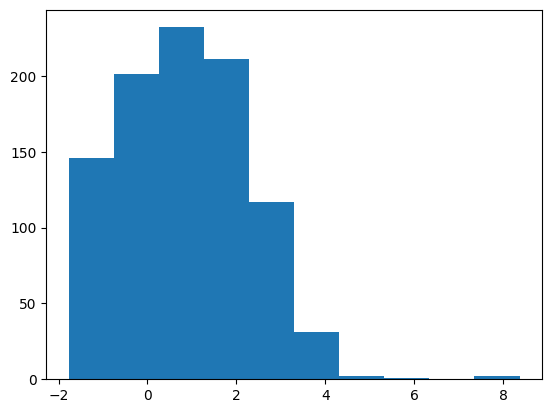

In [295]:
idx_prov = np.where(provincias == 'Cordoba')
plt.hist(relative_density[int(idx_prov[0])])
plt.show()

In [296]:
with open(f'serializables/density.pkl','wb') as f:
    pickle.dump(density_pa, f)

with open(f'serializables/relative_density.pkl','wb') as f:
    pickle.dump(relative_density, f)

## Calcula Valor Estratégico (o COG)
Este indicador mide cuánto se beneficia una provincia *p* al poder especializarse en una nueva actividad *a* en términos de las ganancias en capacidades productivas que se obtienen. Lo que hace es computar la complejidad de las actividades que no se fabrican en esa provincia y la distancia o la proximidad a las capacidades existentes de la nueva actividad *a'*.

$$COG_{pa} = [\sum_{a'} \dfrac{\phi_{a,a'}}{\sum_{a''} \phi_{a'',a'}}(1 - M_{pa'}) ICA_{a'}] - (1 - d_{pa})ICA_{a}$$

In [297]:
non_RCA_all = np.ones((len(provincias), len(actividades)), dtype=np.int64) - Mpa
non_RCA_all = non_RCA_all.astype(float)

distance_pa = np.matmul(non_RCA_all, proximity)

for i in range(len(actividades)):
    distance_pa[:, i] = distance_pa[:, i]/proximity[i, :].sum()

inv_distance_pa = np.ones((len(provincias), len(actividades)), float) - distance_pa

In [298]:
ica_U01 = ica_norm - min(ica_norm)
ica_U01 = ica_U01 / max(ica_U01)

In [299]:
unif_A = np.zeros((len(provincias), len(actividades)), float)
unif_B = np.zeros((len(provincias), len(actividades)), float)
sum_prox = proximity.sum(axis = 0)

for l in range(len(provincias)):
    if l % 13 == 0:
        print('.', end=' ')
        
    for a in range(len(actividades)):
        unif_A[l, a] = (proximity[a, :]*non_RCA_all[l, :]*ica_U01/sum_prox).sum()
        unif_B[l, a] = inv_distance_pa[l, a]*ica_U01[a]

unif_cog2_pa = unif_A - unif_B

. . 

In [300]:
relative_cog = np.zeros((len(provincias), len(actividades)), float)
for idx_prov in range(len(provincias)):
    relative_cog[idx_prov,] = unif_cog2_pa[idx_prov] - unif_cog2_pa[idx_prov][(1 - Mpa[idx_prov]).astype(bool)].mean()
    relative_cog[idx_prov,] /= unif_cog2_pa[idx_prov][(1 - Mpa[idx_prov]).astype(bool)].std()

In [301]:
with open(f'serializables/cog.pkl','wb') as f:
    pickle.dump(unif_cog2_pa, f)

with open(f'serializables/relative_cog.pkl','wb') as f:
    pickle.dump(relative_cog, f)

## Calcula COI
$$COI_p = \sum_{a} (1 - d_{pa})(1 - M_{pa}) ICA_a$$

In [302]:
non_RCA_all = np.ones((len(provincias), len(actividades)), dtype=np.int64) - Mpa
non_RCA_all = non_RCA_all.astype(float)

distance_all_pa = np.matmul(non_RCA_all, proximity)

for i in range(len(actividades)):
    distance_all_pa[:, i] = distance_all_pa[:, i]/proximity[i, :].sum()

In [303]:
inv_distance_all_pa = np.ones((len(provincias), len(actividades)), float) - distance_all_pa

In [304]:
coi_all = np.matmul(non_RCA_all * inv_distance_all_pa, ica_U01)
coi_all_norm = (coi_all - coi_all.mean())/coi_all.std()
pd.DataFrame({'provincia': provincias, 'COI': coi_all_norm})

,provincia,COI
0,Buenos Aires,-2.235414
1,Catamarca,0.151752
2,Cordoba,1.935683
3,Corrientes,0.069207
4,Chaco,0.043819
5,Chubut,0.174324
6,Entre Rios,0.465942
7,Formosa,-0.495230
8,Jujuy,-1.006513
9,La Pampa,0.275371


In [305]:
with open(f'serializables/coi.pkl','wb') as f:
    pickle.dump(coi_all_norm, f)